In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

In [4]:
# 데이터프레임 불러오기
df = pd.read_csv('housingdata.csv')
print(df.info())

# CRIM - 지역별 범죄율 
# ZN - 25000sqft 이상인 주거용 토지 비율 
# INDUS - 지역별 비소매 사업용 토지 비율
# CHAS - CharlesRiver 더미 변수 (강에 인접하면 1, 아니면 0)
# NOX - 일산화질소 농도 (1천만 분율)
# RM - 주택당 평균 방 개수
# AGE - 1940년 이전에 건설된 자가 소유 주택 비율
# DIS - 보스턴 고용센터 5곳까지의 가중 거리
# RAD - 간선 고속도로 접근성 지수
# TAX - $10,000당 부동산 실가치-세율
# PTRATIO - 지역별 학생-교사 비율
# B - 1000(Bk - 0.63)^2 (Bk는 지역별 흑인 비율)
# LSTAT - 저소득층 인구 비율 (%)
# MEDV - 자가 소유 주택의 중위(meadian) 가격 (단위: $1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB
None


In [5]:
df.isna().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [6]:
# 결측치 제거하면
df_na_dropped = df.dropna()
print(df_na_dropped.info())

<class 'pandas.core.frame.DataFrame'>
Index: 394 entries, 0 to 504
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     394 non-null    float64
 1   ZN       394 non-null    float64
 2   INDUS    394 non-null    float64
 3   CHAS     394 non-null    float64
 4   NOX      394 non-null    float64
 5   RM       394 non-null    float64
 6   AGE      394 non-null    float64
 7   DIS      394 non-null    float64
 8   RAD      394 non-null    int64  
 9   TAX      394 non-null    int64  
 10  PTRATIO  394 non-null    float64
 11  B        394 non-null    float64
 12  LSTAT    394 non-null    float64
 13  MEDV     394 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 46.2 KB
None


결측치를 제거한 데이터프레임 df_na_dropped의 정보를 보면 컬럼 수가 394개 밖에 안 남는 것을 알 수 있다

결측치 총 갯수 120개를 원본 컬럼 수 506개에서 뺀 값 386개와 차이가 8개 밖에 안되기에 결측치가 같은 행에 겹치는 경우가 낮다는 것을 알 수 있다

그러므로 결측치는 제거하지 않는다

알고리즘과 플롯으로는 관계성 파악에 진척이없어 dbeaver를 켜 mySQL로 조회를 해보았다

조회 결과 ZN, INDUS, NOX, TAX, RAD이 고정된 값을 갖는 규칙성을 발견했다

사용한 쿼리는 다음과 같다
```
select zn, indus, nox, tax, rad
from housingdata
order by nox desc, tax desc
```


In [7]:
# mySQL쿼리 python으로 구현

# 조회하려는 컬럼 선택
selected_col = df[['ZN', 'INDUS', 'NOX', 'TAX', 'RAD']]

# order by 조건에 맞게 구현
sorted_data = selected_col.sort_values(by=['NOX', 'TAX'], ascending=[False, False])

# 데이터 조회
print(sorted_data.head(10))

      ZN  INDUS    NOX  TAX  RAD
142  0.0  19.58  0.871  403    5
143  0.0  19.58  0.871  403    5
144  0.0  19.58  0.871  403    5
145  0.0  19.58  0.871  403    5
146  NaN  19.58  0.871  403    5
147  0.0    NaN  0.871  403    5
148  0.0    NaN  0.871  403    5
149  0.0  19.58  0.871  403    5
150  0.0  19.58  0.871  403    5
151  0.0  19.58  0.871  403    5


한 눈에 봐도 결측치에 어떤 값을 넣으면 되는 지 알 수 있다

이 규칙성으로 ZN과 INDUS의 결측치를 쉽게 채울 수 있다

In [8]:
# 조회하려는 컬럼
columns_to_check = ['ZN', 'INDUS', 'NOX', 'TAX']

# sql쿼리 조건에 맞춘 sorted_data에서 NaN의 위치
nan_positions = sorted_data[sorted_data[columns_to_check].isna().any(axis=1)].index

# 각 NaN이 있는 행의 주변 행 조회
for pos in range(len(sorted_data)):
    # Check if the current position's index is in nan_positions
    if sorted_data.index[pos] in nan_positions:
        start_pos = max(0, pos - 5)  # Get 5 positions before
        end_pos = min(len(sorted_data), pos + 6)  # Get 5 positions after
        
        print(f"\nNaN found at position {pos} (Index {sorted_data.index[pos]})")
        print("="*50)
        print(sorted_data.iloc[start_pos:end_pos])
        print("\n")


NaN found at position 4 (Index 146)
      ZN  INDUS    NOX  TAX  RAD
142  0.0  19.58  0.871  403    5
143  0.0  19.58  0.871  403    5
144  0.0  19.58  0.871  403    5
145  0.0  19.58  0.871  403    5
146  NaN  19.58  0.871  403    5
147  0.0    NaN  0.871  403    5
148  0.0    NaN  0.871  403    5
149  0.0  19.58  0.871  403    5
150  0.0  19.58  0.871  403    5
151  0.0  19.58  0.871  403    5



NaN found at position 5 (Index 147)
      ZN  INDUS    NOX  TAX  RAD
142  0.0  19.58  0.871  403    5
143  0.0  19.58  0.871  403    5
144  0.0  19.58  0.871  403    5
145  0.0  19.58  0.871  403    5
146  NaN  19.58  0.871  403    5
147  0.0    NaN  0.871  403    5
148  0.0    NaN  0.871  403    5
149  0.0  19.58  0.871  403    5
150  0.0  19.58  0.871  403    5
151  0.0  19.58  0.871  403    5
152  0.0  19.58  0.871  403    5



NaN found at position 6 (Index 148)
      ZN  INDUS    NOX  TAX  RAD
143  0.0  19.58  0.871  403    5
144  0.0  19.58  0.871  403    5
145  0.0  19.58  0.871  403

결측치가 위치하는 행의 주변 위아래 5개 까지 출력하여 찾은 규칙대로 되어 있는지 확인했다

이어서 찾은 규칙대로 결측치를 채워줬다

In [9]:
# NOX, TAX, RAD의 값이 동일한 행의 ZN, INDUS값으로 NaN 채우기
def fill_matching_patterns(df, pattern_cols=['NOX', 'TAX', 'RAD'], fill_cols=['ZN', 'INDUS']):
    
    # 데이터 복제하고
    df_filled = df.copy()
    
    # NaN이 있는 컬럼 찾기
    nan_rows = df_filled[df_filled[fill_cols].isna().any(axis=1)]
    
    for idx in nan_rows.index:
        # NaN이 있는 행의 pattern_cols 값
        pattern_values = df_filled.loc[idx, pattern_cols]
        
        # pattern_cols 값과 일치하는 행 찾기
        matching_mask = True
        for col, val in zip(pattern_cols, pattern_values):
            matching_mask &= (df_filled[col] == val)
        
        # 일치하는 행의 fill_cols 값 가져오기
        matching_rows = df_filled[matching_mask]
        
        # NaN 채우기
        for col in fill_cols:
            if pd.isna(df_filled.loc[idx, col]):
                # 조건에 맞는 값 가져오기
                fill_value = matching_rows[col].dropna().mode().iloc[0] if not matching_rows[col].dropna().empty else None
                if fill_value is not None:
                    df_filled.loc[idx, col] = fill_value
    
    return df_filled

# 함수 적용
df_filled = fill_matching_patterns(df)

실행이 잘 되었나 조회

In [10]:
# 잘 채워졌나 비교
# 원본 df
print("원본 df:")
nan_indices = df[df[['ZN', 'INDUS']].isna().any(axis=1)].index
for idx in nan_indices:
    start_idx = max(0, idx - 2)
    end_idx = min(len(df), idx + 3)
    print(f"\n{idx}번 주위 행:")
    print(df.iloc[start_idx:end_idx])
    
# 채워진 df_filled
print("\n채워진 df:")
for idx in nan_indices:
    start_idx = max(0, idx - 2)
    end_idx = min(len(df), idx + 3)
    print(f"\n{idx}번 주위 행:")
    print(df_filled.iloc[start_idx:end_idx])

원본 df:

36번 주위 행:
       CRIM   ZN  INDUS  CHAS    NOX  ...  TAX  PTRATIO       B  LSTAT  MEDV
34  1.61282  0.0   8.14   0.0  0.538  ...  307     21.0  248.31  20.34  13.5
35  0.06417  0.0   5.96   0.0  0.499  ...  279     19.2  396.90    NaN  18.9
36  0.09744  0.0    NaN   0.0  0.499  ...  279     19.2  377.56  11.41  20.0
37  0.08014  0.0   5.96   0.0  0.499  ...  279     19.2  396.90   8.77  21.0
38  0.17505  0.0   5.96   0.0  0.499  ...  279     19.2  393.43  10.13  24.7

[5 rows x 14 columns]

47번 주위 행:
       CRIM   ZN  INDUS  CHAS    NOX  ...  TAX  PTRATIO       B  LSTAT  MEDV
45  0.17142  0.0   6.91   0.0  0.448  ...  233     17.9  396.90  10.21  19.3
46  0.18836  0.0   6.91   0.0  0.448  ...  233     17.9  396.90  14.15  20.0
47  0.22927  0.0    NaN   0.0  0.448  ...  233     17.9  392.74  18.80  16.6
48  0.25387  0.0   6.91   0.0  0.448  ...  233     17.9  396.90  30.81  14.4
49  0.21977  0.0   6.91   0.0  0.448  ...  233     17.9  396.90  16.20  19.4

[5 rows x 14 columns]



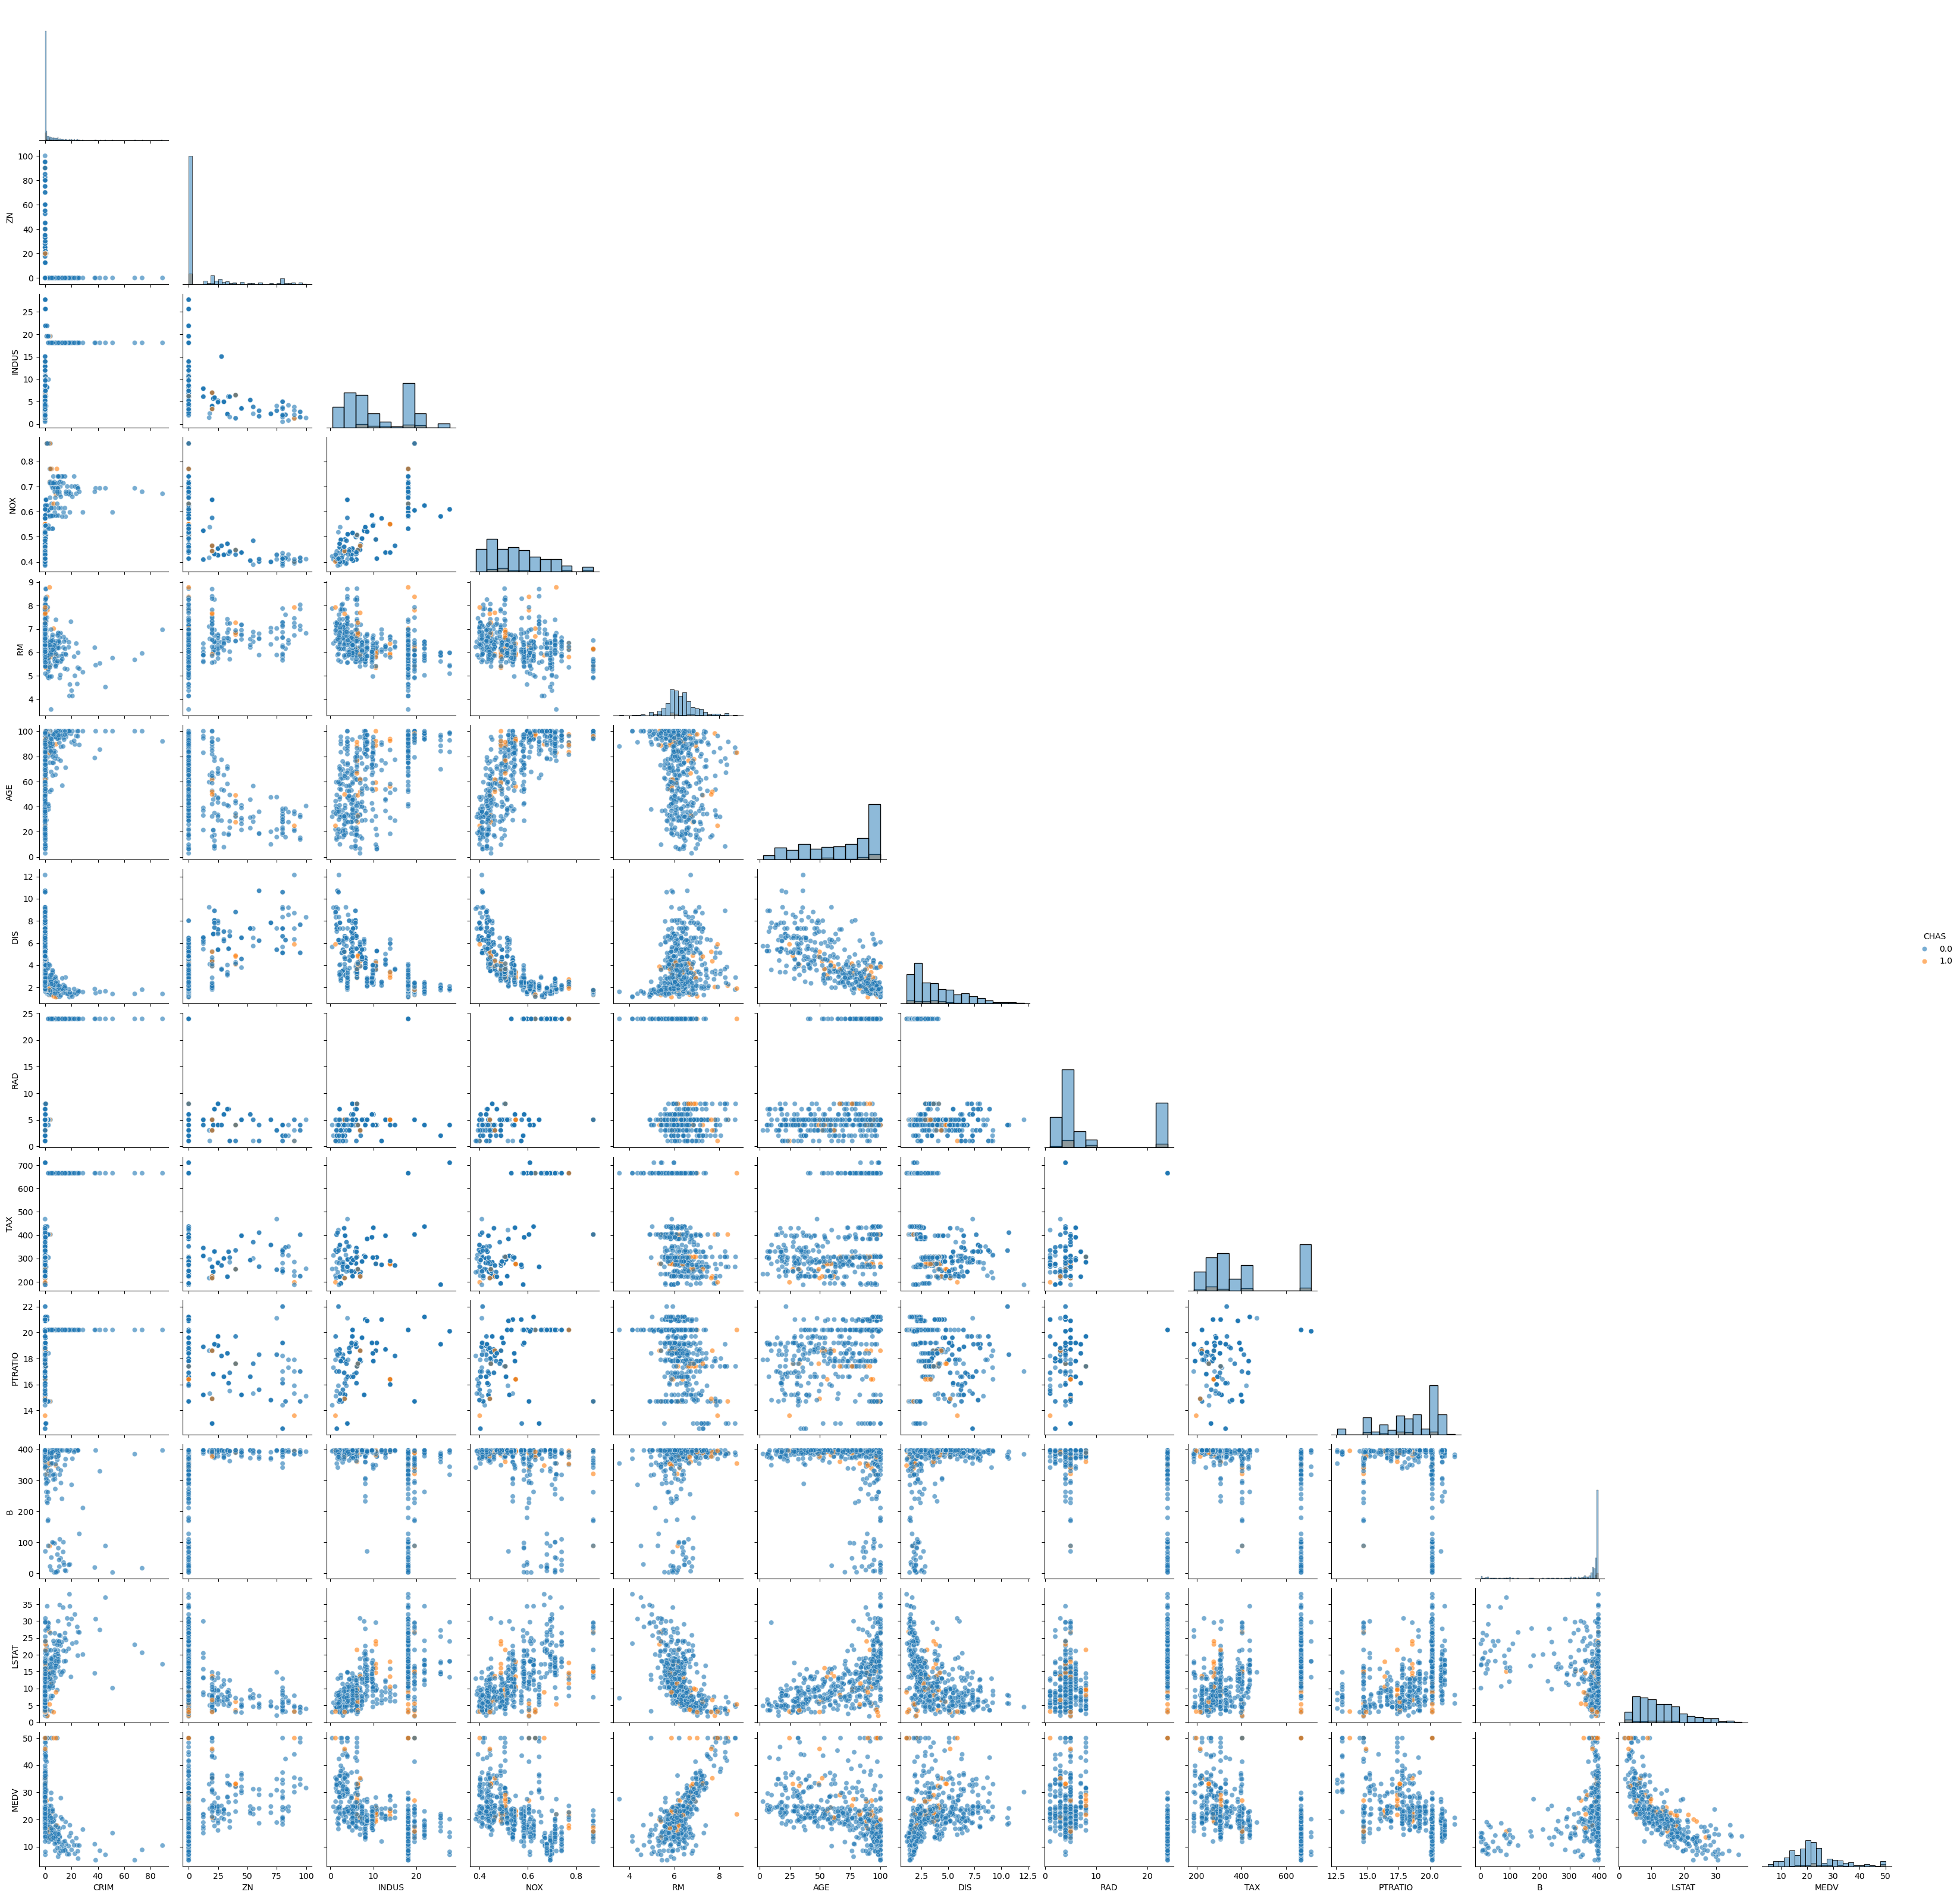

In [11]:
# Create pair plot
sns.pairplot(df_filled, 
             hue='CHAS',
             diag_kind='hist',
             plot_kws={'alpha': 0.6},
             corner=True)
plt.show()

pairplot으로 모든 컬럼들의 상관관계를 scatterplot으로 나타내 보았다

눈에 띄는 점들로는 RAD, TAX, INDUS, ZN, PTRATIO의 일자형태를 띈다

다음으로 과제의 목표가 MEDV를 예측하는 것이니 만큼, MEDV와 연관성이 확연히 보이는 컬럼들로는 LSTAT, RM 그리고 CRIM이 있다

이외에 LSTAT, NOX 와 DIS의 histogram이 비슷한 모양인 것을 보아 연관성이 높은 것으로 보인다

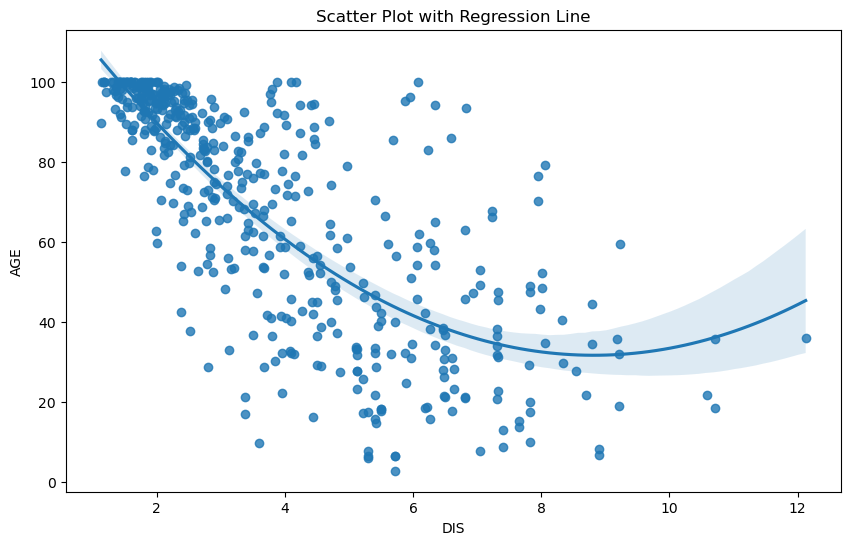

In [12]:
# AGE와 DIS
plt.figure(figsize=(10, 6))
sns.regplot(x='DIS', y='AGE', data=df_filled, order=2)
plt.title('Scatter Plot with Regression Line')
plt.show()

고용센터와 거리가 가까울수록 오래된 자택의 비율이 높아진다

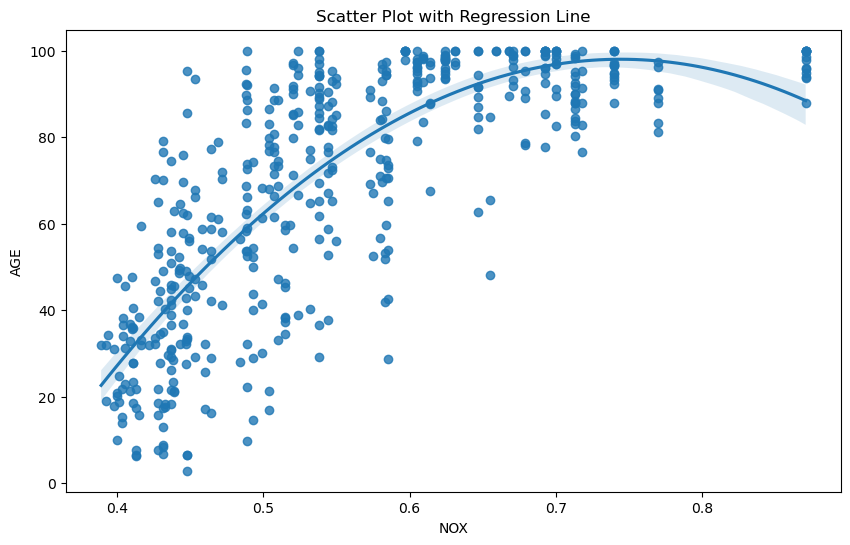

In [13]:
# NOX와 DIS
plt.figure(figsize=(10, 6))
sns.regplot(x='NOX', y='AGE', data=df_filled, order=2)
plt.title('Scatter Plot with Regression Line')
plt.show()

건물이 오래될수록 일산화탄소 수치가 증가한다

이 둘에 의거해 AGE의 결측치를 채워주겠다

In [14]:
# AGE 결측치 여부로 나누기
age_nan = df_filled[df_filled['AGE'].isna()]
age_not_nan = df_filled[~df_filled['AGE'].isna()]
    
# 2차 다항회귀 특성 선택
poly = PolynomialFeatures(degree=2)
X = age_not_nan[['NOX', 'DIS']]
y = age_not_nan['AGE']
    
# 특성 변환
X_poly = poly.fit_transform(X)
    
# 모델 실행
model = LinearRegression()
model.fit(X_poly, y)
    
# 결측치 예측
X_nan = age_nan[['NOX', 'DIS']]
X_nan_poly = poly.transform(X_nan)
predictions = model.predict(X_nan_poly)
    
# 예측한 결측치 채우기
df_filled.loc[age_nan.index, 'AGE'] = predictions

In [15]:
# 결측치 채워졌는지 확인
df_filled.isna().sum()

CRIM       20
ZN          0
INDUS       0
CHAS       20
NOX         0
RM          0
AGE         0
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

AGE의 결측치가 잘 채워졌다

다음은 LSTAT이다

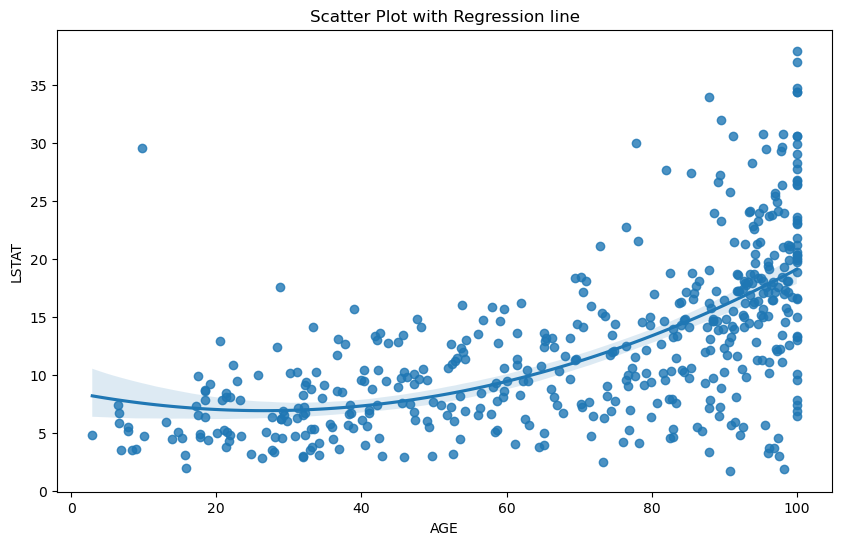

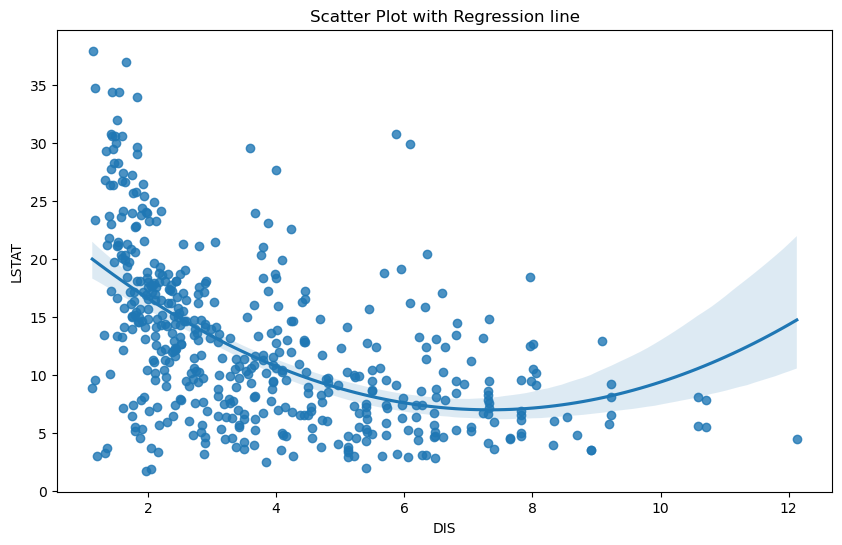

In [16]:
# LSTAT과 AGE의 관계
plt.figure(figsize=(10, 6))
sns.regplot(x='AGE', y='LSTAT', data=df_filled, order=2)
plt.title('Scatter Plot with Regression line')
plt.show()

# LSTAT과 DIS의 관계
plt.figure(figsize=(10, 6))
sns.regplot(x='DIS', y='LSTAT', data=df_filled, order=2)
plt.title('Scatter Plot with Regression line')
plt.show()

AGE와 DIS 둘 다 LSTAT과 어느정도 관계성을 보이는 것을 알 수 있다

사실 MEDV와 관계성이 가장 높았으나 MEDV의 값을 예측해야하는 만큼 MEDV로 결측치를 채우는 것은 피하려 한다

In [17]:
# LSTAT 결측치 여부로 나누기
age_nan = df_filled[df_filled['LSTAT'].isna()]
age_not_nan = df_filled[~df_filled['LSTAT'].isna()]
    
# 2차 다항회귀 특성 선택
poly = PolynomialFeatures(degree=2)
X = age_not_nan[['AGE', 'DIS']]
y = age_not_nan['LSTAT']
    
# 특성 변환
X_poly = poly.fit_transform(X)
    
# 모델 실행
model = LinearRegression()
model.fit(X_poly, y)
    
# 결측치 예측
X_nan = age_nan[['AGE', 'DIS']]
X_nan_poly = poly.transform(X_nan)
predictions = model.predict(X_nan_poly)
    
# 예측한 결측치 채우기
df_filled.loc[age_nan.index, 'LSTAT'] = predictions

In [18]:
# 채워진거 확인
df_filled.isna().sum()

CRIM       20
ZN          0
INDUS       0
CHAS       20
NOX         0
RM          0
AGE         0
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT       0
MEDV        0
dtype: int64

다음으로 CRIM의 결측치를 채워야 한다

CRIM 컬럼의 경우 데이터값의 분포가 매우 이상했는데, 앞서 ZN과 INDUS의 결측치를 채우면서 발견한 규칙에 의하면 ZN(주택용지), INDUS(산업용지), TAX(세금), RAD(고속도로 접근성)이 일정한 고정값을 가진것으로 보아 지리적으로 동일하거나 환경적으로 유사하다는 것으로 생각할 수 있다

그리고 환경적으로 유사하다는 것은 범죄율도 비슷하다고 예측할 수 있을 것이다

이런 생각을 기반으로 SQL로 조회해본 결과 실제로 TAX와 RAD가 일정한 경우 CRIM의 값의 분포가 유사하는 것을 발견했다

사용한 쿼리

```
SELECT crim, tax, rad  
FROM housingdata  
ORDER BY tax, rad ;
```

이를 파이썬으로 구현하면 다음과 같다

In [19]:
selected2 = df_filled[['CRIM', 'TAX', 'RAD']]
sorted_data2 = selected2.sort_values(by=['TAX','RAD'])
print(sorted_data2)

        CRIM  TAX  RAD
353  0.01709  187    5
120  0.06899  188    2
121  0.07165  188    2
122  0.09299  188    2
123  0.15038  188    2
..       ...  ...  ...
488  0.15086  711    4
489  0.18337  711    4
490  0.20746  711    4
491  0.10574  711    4
492  0.11132  711    4

[506 rows x 3 columns]


In [20]:
# TAX, RAD 값이 동일한 행의 CRIM 평균 계산
avg_crim = df.groupby(['TAX', 'RAD'])['CRIM'].mean()

# CRIM의 NaN에 계산한 평균값을 넣어주기
def fill_crim_with_group_avg(row):
    if pd.isna(row['CRIM']):
        # try-accept으로 NaN이면 채우고 아니면 유지
        try:
            return avg_crim[row['TAX'], row['RAD']]
        except KeyError:
            return row['CRIM']
    return row['CRIM'] # NaN이 아니면 유지

# 위의 함수로 결측치 채우기
df_filled['CRIM'] = df_filled.apply(fill_crim_with_group_avg, axis=1)

In [21]:
# 잘 채워졌나 확인
print(df_filled['CRIM'].isna().sum())

0


In [22]:
# 각 TAX, RAD 조합의 CRIM 평균
print(avg_crim)

TAX  RAD
187  5       0.017090
188  2       0.148410
193  3       0.069023
198  1       0.015010
216  3       0.019510
              ...    
432  6       0.143308
437  4       0.589432
469  3       0.013600
666  24     13.011278
711  4       0.151750
Name: CRIM, Length: 77, dtype: float64


TAX가 666, RAD가 24인 구역의 범죄율이 평균 이상으로 높은 것을 알 수 있다

마지막으로 CHAS의 결측치만 남았는데 CHAS(찰스강 인접 여부)와 MEDV(주택 중위가격)의 연관성을 찾기 어렵고, 또한 값을 예측 할 방법을 찾기에는 힘들것으로 생각되기에 생략하기로 결정했다

In [23]:
# CHAS 컬럼 빼기
df_filled = df_filled.drop('CHAS', axis=1)
print(df_filled.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   NOX      506 non-null    float64
 4   RM       506 non-null    float64
 5   AGE      506 non-null    float64
 6   DIS      506 non-null    float64
 7   RAD      506 non-null    int64  
 8   TAX      506 non-null    int64  
 9   PTRATIO  506 non-null    float64
 10  B        506 non-null    float64
 11  LSTAT    506 non-null    float64
 12  MEDV     506 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 51.5 KB
None


다음은 이상치에 대한 처리를 할 차례이다

먼저 각 컬럼 별로 IQR의 upper bound, lower bound와 이상치 갯수를 파악해봤다

In [24]:
def calculate_column_iqr(df):
    # Calculate quartiles and IQR for each column
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculate outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create DataFrame with all statistics
    stats_df = pd.DataFrame({
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Outliers_Count': [sum((df[col] < lower_bound[col]) | (df[col] > upper_bound[col])) for col in df.columns]
    })
    
    return stats_df

# Example usage:
iqr_stats = calculate_column_iqr(df_filled)
print(iqr_stats)

         Lower_Bound  Upper_Bound  Outliers_Count
CRIM       -5.329331     9.100619              71
ZN        -18.750000    31.250000              68
INDUS     -14.175000    37.465000               0
NOX         0.186500     0.886500               0
RM          4.778500     7.730500              30
AGE       -26.775000   165.825000               0
DIS        -2.532200     9.820800               5
RAD       -26.000000    54.000000               0
TAX      -301.500000  1246.500000               0
PTRATIO    13.200000    24.400000              15
B         344.106250   427.496250              77
LSTAT      -7.420000    31.580000               7
MEDV        5.062500    36.962500              40


ZN, INDUS, PTRATIO의 경우 고정된 값을 가지기에 이상치의 여부가 크게 중요하지 않을 것으로 생각된다  

나머지 컬럼들은 역시나 이상치가 분포한 경우가 RAD, TAX가 일정한 경향을 보이기에 CRIM의 결측치를 채운 것 처럼 RAD, TAX가 일치하는 행들의 최소, 최대 값으로 대체할 수 있을 것 같다

In [25]:
def replace_outliers_by_group(df, columns_to_process, group_cols=['TAX', 'RAD']):
    # columns_to_process는 적용하려는 컬럼
    
    df_processed = df.copy()
    
    # 각 컬럼에 적용
    for col in columns_to_process:
        # IQR 계산
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # TAX, RAD가 동일한 열끼리 group으로 묶기
        for name, group in df.groupby(group_cols):
            # 만약 TAX, RAD가 동일한 열이 하나라면 Q1 또는 Q3 적용
            if len(group) <= 1:
                mask = True
                for gc, gn in zip(group_cols, name):
                    mask = mask & (df_processed[gc] == gn)
                
                # 현재 값 불러오기
                current_value = group[col].iloc[0]
                
                # 값의 크기에 맞춰 Q1, Q3로 채우기
                if current_value < lower_bound:
                    df_processed.loc[mask, col] = Q1
                elif current_value > upper_bound:
                    df_processed.loc[mask, col] = Q3
            else:
                # 각 group에 적용
                mask = True
                for gc, gn in zip(group_cols, name):
                    mask = mask & (df_processed[gc] == gn)
            
                # 이상치를 제외한 group내의 최소, 최댓값 구하기
                valid_values = group[col][(group[col] >= lower_bound) & 
                                          (group[col] <= upper_bound)]
            
                if len(valid_values) > 0:
                    group_valid_min = valid_values.min()
                    group_valid_max = valid_values.max()
                
                    # group내의 최소, 최댓값으로 이상치 대체
                    df_processed.loc[mask & (df_processed[col] < lower_bound), col] = group_valid_min
                    df_processed.loc[mask & (df_processed[col] > upper_bound), col] = group_valid_max
    
    return df_processed


In [26]:
# 이상치 대체하는 함수 적용
columns_to_process = ['CRIM', 'RM', 'DIS', 'B', 'LSTAT']
df_cleaned = replace_outliers_by_group(df_filled, columns_to_process)

In [27]:
iqr_cleaned = calculate_column_iqr(df_cleaned)
print(iqr_cleaned)

         Lower_Bound  Upper_Bound  Outliers_Count
CRIM       -5.329331     9.100619               0
ZN        -18.750000    31.250000              68
INDUS     -14.175000    37.465000               0
NOX         0.186500     0.886500               0
RM          4.780187     7.727688               2
AGE       -26.775000   165.825000               0
DIS        -2.505791     9.776784               4
RAD       -26.000000    54.000000               0
TAX      -301.500000  1246.500000               0
PTRATIO    13.200000    24.400000              15
B         345.956250   426.386250               2
LSTAT      -7.420000    31.580000               0
MEDV        5.062500    36.962500              40


함수를 적용했는데도 이상치가 완전히 제거되지 않았다

완전히 없어질 때 까지 반복하기에는 어려우니 만족하고 다음 단계로 넘어가겠다

In [28]:
# 특성과 타겟 설정
X = df_cleaned.drop('MEDV', axis=1)
y = df_cleaned['MEDV']

# 훈련과 테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


=== Linear Regression ===
MSE: 22.86375808940268
R2 Score: 0.6882233930381345

=== Polynomial Regression ===
MSE: 13.660542053094396
R2 Score: 0.8137210237302281

=== Ridge Regression ===
MSE: 22.906783183131704
R2 Score: 0.688

=== Lasso Regression ===
MSE: 26.124804677744265
R2 Score: 0.644


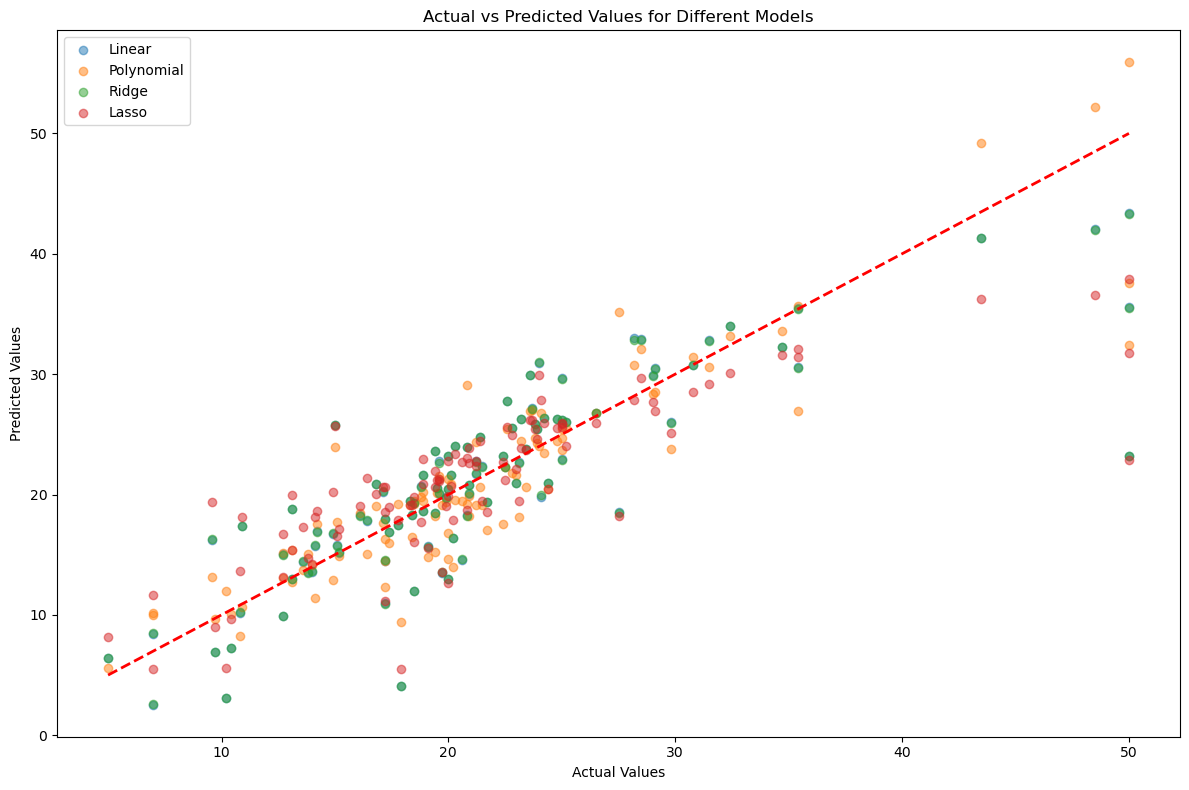

In [29]:
# 1. 선형회귀
# 모델 생성
print("\n=== Linear Regression ===")

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 훈련
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# 예측 및 평가
y_pred_linear = linear_model.predict(X_test_scaled)
print(f'MSE: {mean_squared_error(y_test, y_pred_linear)}')
print(f'R2 Score: {r2_score(y_test, y_pred_linear)}')

# 2. 다항회귀
print("\n=== Polynomial Regression ===")

# 특성 선택
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

# 데이터 정규화
scaler_poly = StandardScaler()
X_poly_train_scaled = scaler_poly.fit_transform(X_poly_train)
X_poly_test_scaled = scaler_poly.transform(X_poly_test)

# 훈련
poly_model = LinearRegression()
poly_model.fit(X_poly_train_scaled, y_train)

# 예측 및 평가
y_pred_poly = poly_model.predict(X_poly_test_scaled)
print(f'MSE: {mean_squared_error(y_test, y_pred_poly)}')
print(f'R2 Score: {r2_score(y_test, y_pred_poly)}')

# 3. 리지회귀
print("\n=== Ridge Regression ===")

# 모델 생성
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

# 예측 및 평가
y_pred_ridge = ridge_model.predict(X_test_scaled)
print(f'MSE: {mean_squared_error(y_test, y_pred_ridge)}')
print(f'R2 Score: {r2_score(y_test, y_pred_ridge):.3f}')

# 4. 라쏘회귀
print("\n=== Lasso Regression ===")

# 모델 생성
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train_scaled, y_train)

# 예측 및 평가
y_pred_lasso = lasso_model.predict(X_test_scaled)
print(f'MSE: {mean_squared_error(y_test, y_pred_lasso)}')
print(f'R2 Score: {r2_score(y_test, y_pred_lasso):.3f}')

# 결과 시각화 및 비교
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred_linear, alpha=0.5, label='Linear')
plt.scatter(y_test, y_pred_poly, alpha=0.5, label='Polynomial')
plt.scatter(y_test, y_pred_ridge, alpha=0.5, label='Ridge')
plt.scatter(y_test, y_pred_lasso, alpha=0.5, label='Lasso')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Different Models')
plt.legend()
plt.tight_layout()
plt.show()


=== SVR ===
MSE: 16.47065166206358
R2 Score: 0.7754015822959073

=== Neural Network ===
MSE: 16.845001136965635
R2 Score: 0.7702968480415234

=== KNN ===
MSE: 18.13316862745098
R2 Score: 0.7527310354654949


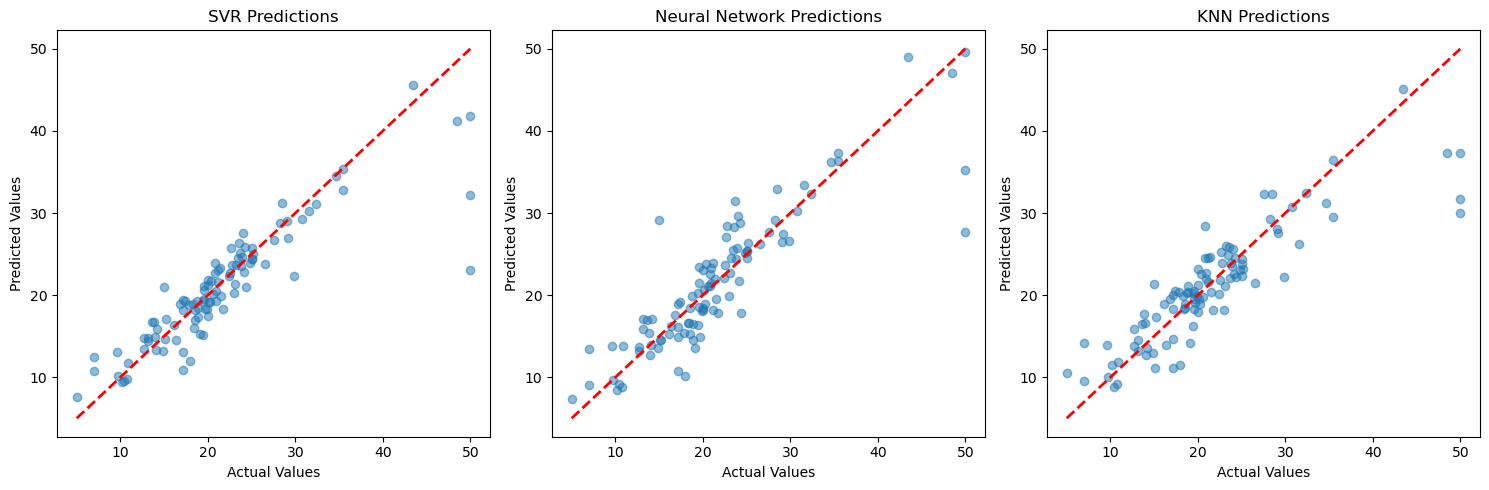

In [30]:

# 데이터 정규화
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# 1. SVR모델
# 모델 생성
print("\n=== SVR ===")
svr_model = SVR(kernel='rbf')  # radial basis function kernel
svr_model.fit(X_train_scaled, y_train_scaled)

# 예측 및 평가
y_pred_svr_scaled = svr_model.predict(X_test_scaled)
y_pred_svr = scaler_y.inverse_transform(y_pred_svr_scaled.reshape(-1, 1)).ravel()
print(f'MSE: {mean_squared_error(y_test, y_pred_svr)}')
print(f'R2 Score: {r2_score(y_test, y_pred_svr)}')


# 2. MLP(Neural Networks)
# 모델 생성
print("\n=== Neural Network ===")
nn_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    max_iter=1000,
    random_state=42
)
nn_model.fit(X_train_scaled, y_train)

# 예측 및 평가
y_pred_nn = nn_model.predict(X_test_scaled)
print(f'MSE: {mean_squared_error(y_test, y_pred_nn)}')
print(f'R2 Score: {r2_score(y_test, y_pred_nn)}')

# 3. KNN(K-Nearest Neighbors)
# 모델 생성
print("\n=== KNN ===")
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# 예측 및 평가
y_pred_knn = knn_model.predict(X_test_scaled)
print(f'MSE: {mean_squared_error(y_test, y_pred_knn)}')
print(f'R2 Score: {r2_score(y_test, y_pred_knn)}')

# 각 모델 시각화 및 비교
plt.figure(figsize=(15, 5))

# SVR
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_svr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR Predictions')

# Neural Network
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_nn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Neural Network Predictions')

# KNN
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_knn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('KNN Predictions')

plt.tight_layout()
plt.show()


=== Decision Tree ===
MSE: 11.815294117647055
R2 Score: 0.8388833412314709

=== Random Forest ===
MSE: 9.420753450980397
R2 Score: 0.8715359682128404

=== XGBoost ===
MSE: 10.514553224528118
R2 Score: 0.8566206082462552


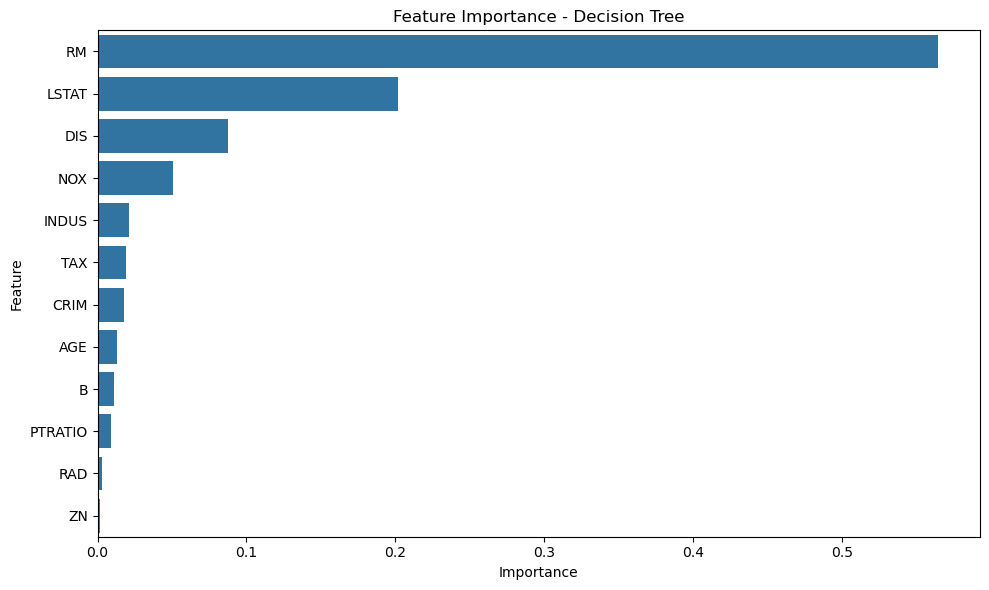

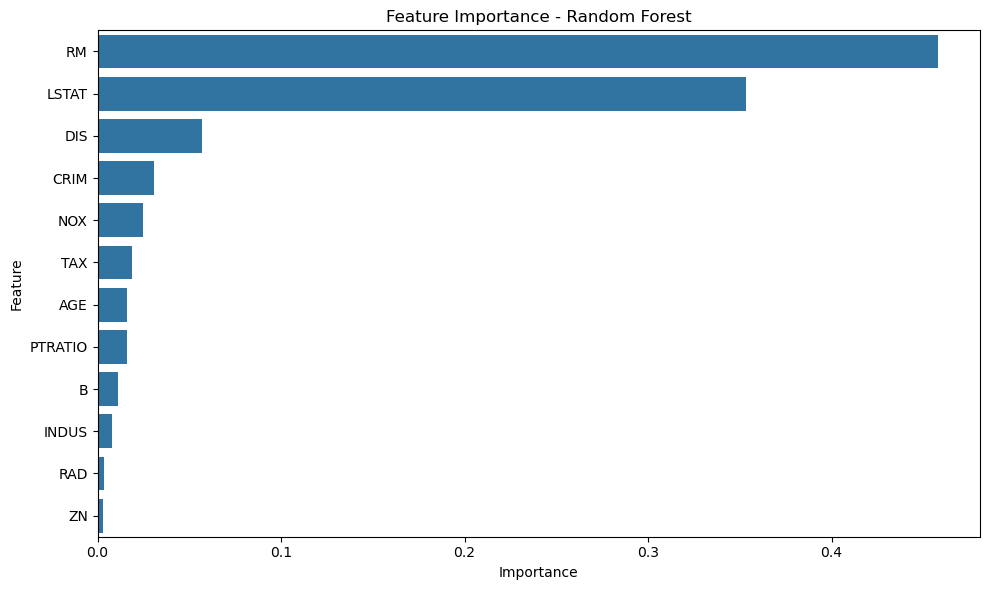

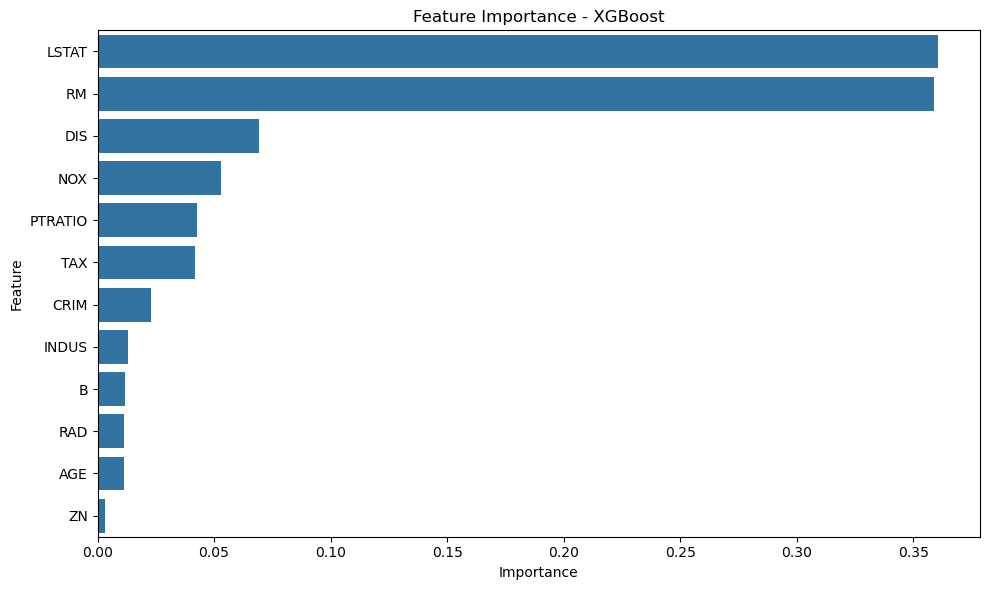

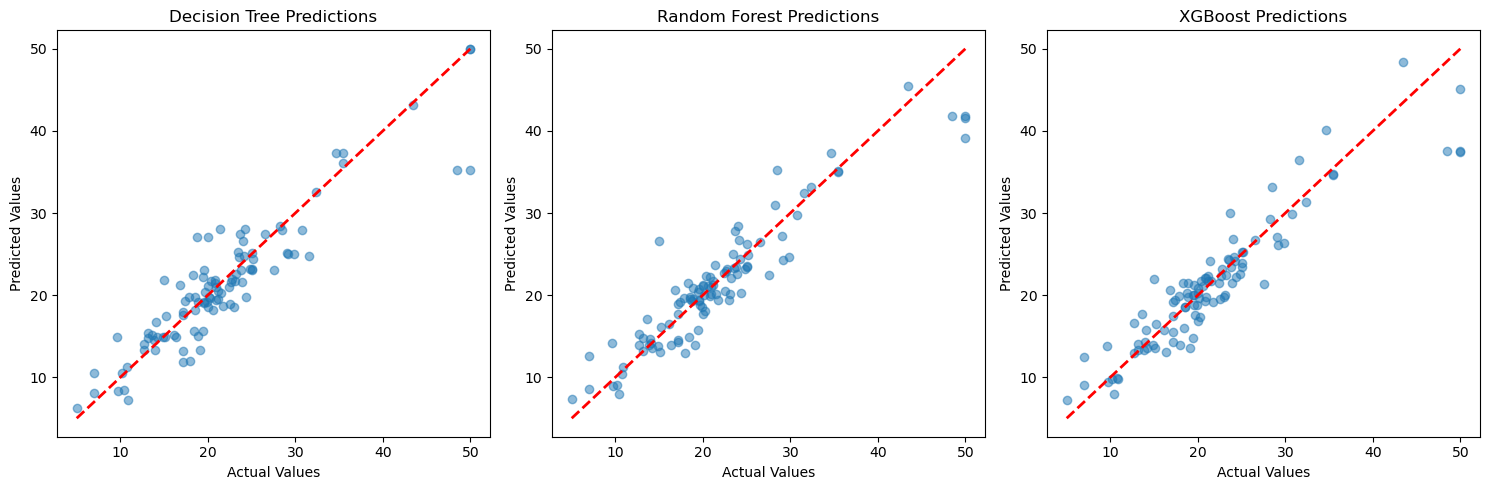

In [32]:
# 1. 의사결정나무(Decision Tree)
print("\n=== Decision Tree ===")

# 모델 생성
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# 예측 및 평가
y_pred_dt = dt_model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred_dt)}')
print(f'R2 Score: {r2_score(y_test, y_pred_dt)}')

# 2. 랜텀포레스트(Random Forest)
print("\n=== Random Forest ===")

# 모델 생성
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 평가
y_pred_rf = rf_model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred_rf)}')
print(f'R2 Score: {r2_score(y_test, y_pred_rf)}')

# 3. XGBoost(Extreme Gradient Boosting)
print("\n=== XGBoost ===")

# 모델 생성
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 예측 및 평가
y_pred_xgb = xgb_model.predict(X_test)
print(f'MSE: {mean_squared_error(y_test, y_pred_xgb)}')
print(f'R2 Score: {r2_score(y_test, y_pred_xgb)}')

# 특성 중요도 모델별로 비교
def plot_feature_importance(model, title):
    importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    })
    importance = importance.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance, x='Importance', y='Feature')
    plt.title(f'Feature Importance - {title}')
    plt.tight_layout()
    plt.show()

# 각 모델별 특성 중요도
plot_feature_importance(dt_model, 'Decision Tree')
plot_feature_importance(rf_model, 'Random Forest')
plot_feature_importance(xgb_model, 'XGBoost')

# 예측 결과 시각화
plt.figure(figsize=(15, 5))

# 의사결정나무
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_dt, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Predictions')

# 랜덤 포레스트
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Predictions')

# XGBoost
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Predictions')

plt.tight_layout()
plt.show()

표준화 필요 여부와 비슷한 모델끼리 묶어 평가했다

결과적으로 랜덤 포레스트 모델의 정확도가 가장 높았다